## Method 1 (Combastel 2003)

In [4]:
using Revise, ReachabilityAnalysis, Test, BenchmarkTools, Plots
using StaticArrays

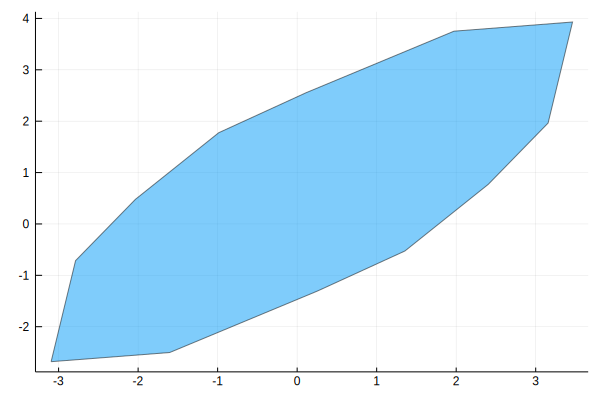

In [47]:
Z = Zonotope(rand(2), rand(2, 6)); # order 3
plot(Z)

In [44]:
# compute the interval hull
M = Z.generators

2×10 Array{Float64,2}:
 0.569054  0.122998  0.295936  0.0510516  …  0.82904   0.65224  0.576509
 0.187848  0.36725   0.783097  0.174121      0.238775  0.58694  0.404778

In [24]:
sum(abs.(M), dims=2)

2×1 Array{Float64,2}:
 2.2718354808591217
 2.6949894545555884

In [37]:
# interval hull
function interval_hull_v0(G::Matrix{N}) where {N}
    n = size(G, 1)
    Gsum = sum(abs.(G), dims=2)
    Gbox = zeros(N, n, n)
    @inbounds for i in 1:n
        Gbox[i, i] = Gsum[i]
    end
    return Gbox
end

interval_hull_v0 (generic function with 1 method)

In [42]:
@btime interval_hull_v0($M) # order 3

  535.608 ns (9 allocations: 576 bytes)


2×2 Array{Float64,2}:
 3.08868  0.0
 0.0      3.00576

In [45]:
@btime interval_hull_v0($M) # order 10

  552.107 ns (9 allocations: 640 bytes)


2×2 Array{Float64,2}:
 4.31308  0.0
 0.0      3.86407

In [34]:
# interval hull
function interval_hull(G::Matrix{N}) where {N}
    n, p = size(G)
    Gbox = zeros(N, n, n)
    @inbounds for i in 1:n
        for j in 1:p
            Gbox[i, i] += abs(G[i, j])
        end
    end
    return Gbox
end

interval_hull (generic function with 1 method)

In [35]:
@btime interval_hull($M) # order 10

  38.217 ns (1 allocation: 112 bytes)


2×2 Array{Float64,2}:
 6.57925  0.0
 0.0      4.75817

In [46]:
@btime interval_hull($M) # order 3

  38.298 ns (1 allocation: 112 bytes)


2×2 Array{Float64,2}:
 4.31308  0.0
 0.0      3.86407

Example:

In [50]:
function interval_hull(Z::Zonotope)
    Zonotope(Z.center, interval_hull(Z.generators))
end

interval_hull (generic function with 2 methods)

In [82]:
Z

Zonotope{Float64,Array{Float64,1},Array{Float64,2}}([0.5680414549351669, 0.6271652184216445], [0.28161605196515205 -0.3209667418511202 … -0.2670767663612974 0.2444286112146754; -0.4478900355327835 -0.37906366892683785 … -0.2530432395046349 0.14618542154448555])

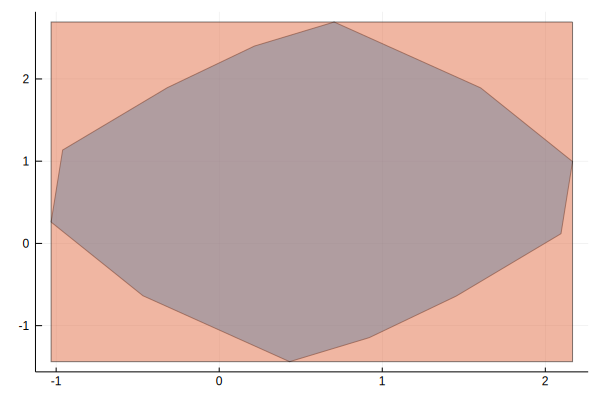

In [89]:
#Z = rand(Zonotope)
plot(Z)
plot!(interval_hull(Z))

Chaning the order

In [308]:
using LoopVectorization

┌ Info: Precompiling LoopVectorization [bdcacae8-1622-11e9-2a5c-532679323890]
└ @ Base loading.jl:1260


In [319]:
# interval hull
function interval_hull_avx(G::Matrix{N}) where {N}
    n, p = size(G)
    Gbox = zeros(N, n, n)
    @avx for j in 1:p
        for i in 1:n
            Gbox[i, i] += abs(G[i, j])
        end
    end
    return Gbox
end

interval_hull_avx (generic function with 1 method)

In [314]:
G = rand(3, 20) .- 0.5;

In [320]:
@btime interval_hull_avx($G)

  47.666 ns (1 allocation: 160 bytes)


3×3 Array{Float64,2}:
 4.66442  0.0      0.0
 0.0      4.55711  0.0
 0.0      0.0      3.54845

In [318]:
@btime interval_hull($G)

  62.164 ns (1 allocation: 160 bytes)


3×3 Array{Float64,2}:
 4.66442  0.0      0.0
 0.0      4.55711  0.0
 0.0      0.0      3.54845

---

**Sorting**

In [80]:
Z = Zonotope(rand(2), rand(2, 6) .- 0.5)
M = Z.generators

2×6 Array{Float64,2}:
  0.281616  -0.320967  -0.449456  -0.0353958  -0.267077  0.244429
 -0.44789   -0.379064   0.400732  -0.438377   -0.253043  0.146185

In [138]:
function sort_gens(G::Matrix{N}) where {N}
    p = size(G, 2)
    weights = zeros(N, p)
    @inbounds for i in 1:p
        weights[i] = norm(view(G, :, i), 2)
    end
    indices = sortperm(weights, rev=false) # ordena de menor a mayor

    weights, indices
end

sort_gens (generic function with 1 method)

In [139]:
weights, indices = sort_gens(M)
@show weights
@show indices;
@btime sort_gens($M)

weights = [0.5290681285562354, 0.496698011345726, 0.6021596560622862, 0.43980407256177734, 0.3679142293918612, 0.28480787112099604]
indices = [6, 5, 4, 2, 1, 3]
  255.749 ns (12 allocations: 624 bytes)


([0.5290681285562354, 0.496698011345726, 0.6021596560622862, 0.43980407256177734, 0.3679142293918612, 0.28480787112099604], [6, 5, 4, 2, 1, 3])

In [204]:
function sort_gens2(G::Matrix{N}) where {N}
    p = size(G, 2)
    weights = zeros(N, p)
    @inbounds for i in 1:p
        weights[i] = norm(view(G, :, i), 2)
    end
    indices = Vector{Int}(undef, p)
    sortperm!(indices, weights, rev=true, initialized=false)

    weights, indices
end

sort_gens2 (generic function with 1 method)

In [137]:
weights, indices = sort_gens2(M)
@show weights
@show indices;
@btime sort_gens2($M)

weights = [0.5290681285562354, 0.496698011345726, 0.6021596560622862, 0.43980407256177734, 0.3679142293918612, 0.28480787112099604]
indices = [6, 5, 4, 2, 1, 3]
  255.234 ns (12 allocations: 624 bytes)


([0.5290681285562354, 0.496698011345726, 0.6021596560622862, 0.43980407256177734, 0.3679142293918612, 0.28480787112099604], [6, 5, 4, 2, 1, 3])

In [221]:
function sort_gens_partial(G::Matrix{N}, m::Int) where {N}
    p = size(G, 2)
    weights = zeros(N, p)
    @inbounds for i in 1:p
        weights[i] = norm(view(G, :, i), 2)
    end
    indices = [1:p;]
    partialsortperm!(indices, weights, 1:m, rev=true, initialized=true)

    weights, indices
end

sort_gens_partial (generic function with 1 method)

In [352]:
function ordenar(weights)
    p = length(weights)
    indices = Vector{Int}(undef, p)
    sortperm!(indices, weights, rev=false, initialized=false)
    return indices
end

function ordenar_parcial(weights, m)
    p = length(weights)
    partialsortperm(weights, m, rev=false, alg=MergeSort)
end

function ordenar_parcial2(weights, m)
    sortperm(weights; alg=PartialQuickSort(m))
end

ordenar_parcial2 (generic function with 1 method)

In [353]:
weights = rand(1000) .- 0.5;

In [354]:
@show ordenar(weights);
@show ordenar_parcial(weights, 4);
@show ordenar_parcial2(weights, 4);

ordenar(weights) = [414, 836, 422, 613, 838, 116, 473, 823, 911, 220, 709, 272, 167, 423, 596, 343, 32, 553, 498, 786, 995, 852, 165, 700, 839, 15, 741, 628, 107, 627, 545, 534, 584, 48, 742, 2, 252, 810, 97, 617, 146, 999, 233, 89, 219, 952, 389, 788, 996, 803, 143, 392, 757, 351, 530, 383, 14, 693, 703, 245, 63, 202, 344, 589, 106, 948, 691, 196, 960, 438, 234, 884, 330, 640, 848, 427, 629, 725, 13, 795, 470, 608, 487, 845, 739, 454, 745, 962, 391, 754, 226, 466, 949, 214, 173, 352, 972, 50, 254, 273, 285, 893, 804, 318, 633, 859, 336, 561, 400, 376, 357, 105, 432, 868, 112, 380, 632, 684, 369, 60, 894, 382, 609, 335, 819, 809, 736, 76, 523, 482, 396, 918, 247, 953, 653, 144, 337, 440, 184, 671, 88, 157, 210, 387, 978, 618, 892, 869, 286, 820, 259, 443, 408, 639, 201, 908, 966, 998, 563, 462, 682, 968, 390, 359, 923, 217, 576, 669, 95, 940, 783, 664, 56, 195, 573, 955, 890, 502, 244, 109, 275, 843, 572, 29, 826, 346, 153, 853, 651, 969, 986, 546, 197, 605, 215, 883, 5, 85, 769, 483, 

MethodError: MethodError: no method matching partialsortperm!(::Array{Int64,1}, ::Array{Float64,1}, ::Int64; rev=false, alg=Base.Sort.MergeSortAlg(), initialized=false)
Closest candidates are:
  partialsortperm!(::AbstractArray{#s659,1} where #s659<:Integer, ::AbstractArray{T,1} where T, ::Union{Integer, OrdinalRange}; lt, by, rev, order, initialized) at sort.jl:845 got unsupported keyword argument "alg"

In [357]:
?sort

search: sort sort! sortperm sortperm! sort_gens sortslices sort_gens2



```
sort(v; alg::Algorithm=defalg(v), lt=isless, by=identity, rev::Bool=false, order::Ordering=Forward)
```

Variant of [`sort!`](@ref) that returns a sorted copy of `v` leaving `v` itself unmodified.

# Examples

```jldoctest
julia> v = [3, 1, 2];

julia> sort(v)
3-element Array{Int64,1}:
 1
 2
 3

julia> v
3-element Array{Int64,1}:
 3
 1
 2
```

---

```
sort(A; dims::Integer, alg::Algorithm=DEFAULT_UNSTABLE, lt=isless, by=identity, rev::Bool=false, order::Ordering=Forward)
```

Sort a multidimensional array `A` along the given dimension. See [`sort!`](@ref) for a description of possible keyword arguments.

To sort slices of an array, refer to [`sortslices`](@ref).

# Examples

```jldoctest
julia> A = [4 3; 1 2]
2×2 Array{Int64,2}:
 4  3
 1  2

julia> sort(A, dims = 1)
2×2 Array{Int64,2}:
 1  2
 4  3

julia> sort(A, dims = 2)
2×2 Array{Int64,2}:
 3  4
 1  2
```

---

```
sort(parameters::Vector, order::Tuple)
```

Filter and sort the vector `parameters` according to `order`.

### Input

  * `parameters` – vector of tuples
  * `order`      – tuple of symbols

### Output

A new vector of tuples corresponding to `parameters` filtered and sorted according to `order`.

### Examples

```jldoctest
julia> parameters= [(:U1, :U), (:X1, :X), (:W1, :W)];

julia> sort(parameters, (:X, :U, :W))
3-element Array{Tuple{Any,Symbol},1}:
 (:X1, :X)
 (:U1, :U)
 (:W1, :W)

julia>  parameters = [(:const, :c), (:A, :A)];

julia> sort(parameters, (:A, :B, :c, :D))
2-element Array{Tuple{Any,Symbol},1}:
 (:A, :A)
 (:const, :c)
```

### Notes

`parameters` is a vector that contains tuples whose second element is considered for the sorting according to `order`.

If a value of `order` is not contained in `parameters`, the corresponding entry of `order` will be omitted.


In [351]:
@btime ordenar($weights);
@btime ordenar_parcial($weights, 4);
@btime ordenar_parcial2($weights, 4);

  21.414 μs (4 allocations: 7.98 KiB)
  11.735 μs (3 allocations: 7.97 KiB)
  11.869 μs (3 allocations: 7.97 KiB)


In [222]:
M = rand(3, 20) .- 0.5;

In [223]:
weights, indices = sort_gens_partial(M, 3)
@btime sort_gens_partial($M, 3)

  866.949 ns (26 allocations: 1.53 KiB)


([0.5418556576014054, 0.6376114530568366, 0.6517988869384466, 0.549504845032359, 0.6920728992613562, 0.6289673404321229, 0.3681561542158848, 0.6085334801996619, 0.24222904667797338, 0.4743478377653587, 0.49198424779384486, 0.5081295421282085, 0.2905420486410917, 0.430616149318117, 0.6544704420391821, 0.6569162461795516, 0.6077802596790824, 0.5714812817550053, 0.3941155390512953, 0.5520421444336712], [5, 16, 15, 3, 2, 6, 8, 17, 18, 20, 4, 1, 12, 11, 10, 14, 19, 7, 13, 9])

In [224]:
weights, indices = sort_gens2(M)
@btime sort_gens2($M)

  606.802 ns (26 allocations: 1.48 KiB)


([0.5418556576014054, 0.6376114530568366, 0.6517988869384466, 0.549504845032359, 0.6920728992613562, 0.6289673404321229, 0.3681561542158848, 0.6085334801996619, 0.24222904667797338, 0.4743478377653587, 0.49198424779384486, 0.5081295421282085, 0.2905420486410917, 0.430616149318117, 0.6544704420391821, 0.6569162461795516, 0.6077802596790824, 0.5714812817550053, 0.3941155390512953, 0.5520421444336712], [5, 16, 15, 3, 2, 6, 8, 17, 18, 20, 4, 1, 12, 11, 10, 14, 19, 7, 13, 9])

In [178]:
?partialsortperm!

search: partialsortperm! partialsortperm partialsort! partialsort



```
partialsortperm!(ix, v, k; by=<transform>, lt=<comparison>, rev=false, initialized=false)
```

Like [`partialsortperm`](@ref), but accepts a preallocated index vector `ix` the same size as `v`, which is used to store (a permutation of) the indices of `v`.

If the index vector `ix` is initialized with the indices of `v` (or a permutation thereof), `initialized` should be set to `true`.

If `initialized` is `false` (the default), then `ix` is initialized to contain the indices of `v`.

If `initialized` is `true`, but `ix` does not contain (a permutation of) the indices of `v`, the behavior of `partialsortperm!` is undefined.

(Typically, the indices of `v` will be `1:length(v)`, although if `v` has an alternative array type with non-one-based indices, such as an `OffsetArray`, `ix` must also be an `OffsetArray` with the same indices, and must contain as values (a permutation of) these same indices.)

Upon return, `ix` is guaranteed to have the indices `k` in their sorted positions, such that

```julia
partialsortperm!(ix, v, k);
v[ix[k]] == partialsort(v, k)
```

The return value is the `k`th element of `ix` if `k` is an integer, or view into `ix` if `k` is a range.

# Examples

```jldoctest
julia> v = [3, 1, 2, 1];

julia> ix = Vector{Int}(undef, 4);

julia> partialsortperm!(ix, v, 1)
2

julia> ix = [1:4;];

julia> partialsortperm!(ix, v, 2:3, initialized=true)
2-element view(::Array{Int64,1}, 2:3) with eltype Int64:
 4
 3
```

```

```


In [96]:
@btime sort_gens($M)

  272.756 ns (7 allocations: 704 bytes)


6-element Array{Float64,1}:
 0.5290681285562354
 0.496698011345726
 0.6021596560622862
 0.43980407256177734
 0.3679142293918612
 0.28480787112099604

In [94]:
M[1, 1]^2 + M[2, 1]^2 |> sqrt

0.5290681285562354

In [92]:
@btime sort_gens($M)

6-element Array{Float64,1}:
 0.5290681285562354
 0.496698011345726
 0.6021596560622862
 0.43980407256177734
 0.3679142293918612
 0.28480787112099604

In [282]:
# return a zonotope whose order is r (if possible), otherwise the order is the
# closest integer (floor)
# assume that r >= 1
using LazySets: center

function _reduce_order_combastel(Z::Zonotope{N, MN}, r::Number) where {N, MN}
    r >= 1 || throw(ArgumentError("the target order should be at least 1, but it is $r"))
    c = Z.center
    G = Z.generators
    n, p = size(G)
    
    (r * n >= p) && return Z  # do not reduce

    # compute interval hull of L
    Lred = zeros(N, n, n)
    @inbounds for i in 1:n
        for j in 1:p
            Lred[i, i] += abs(G[i, j])
        end
    end

    if r == 1
        return Zonotope(c, Lred)
    end

    # split Z into K and L
    # sort generators by decreasing 2-norm
    weights = zeros(N, p)
    @inbounds for i in 1:p
        weights[i] = norm(view(G, :, i), 2)
    end
    indices = Vector{Int}(undef, p)
    sortperm!(indices, weights, rev=true, initialized=false)

    m = floor(Int, n * (r - 1))
    Gred = hcat(G[:, indices[1:m]], Lred)
    return Zonotope(c, Gred)
end

_reduce_order_combastel (generic function with 2 methods)

In [262]:
Z = Zonotope(rand(2), rand(2, 20) .- 0.5);
order(Z) * 1.0

10.0

### Reduction to order 1

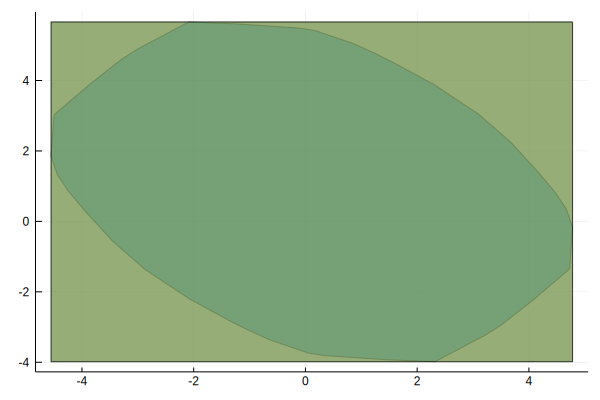

In [264]:
plot(Z)
plot!(_reduce_order_combastel(Z, 1))
plot!(LazySets.reduce_order(Z, 1))

In [265]:
@btime _reduce_order_combastel($Z, 1) # reduccion a orden 1

  62.446 ns (2 allocations: 144 bytes)


Zonotope{Float64,Array{Float64,1},Array{Float64,2}}([0.11452054536894174, 0.8389944773210667], [4.666755122634283 0.0; 0.0 4.822403971457481])

In [266]:
@btime LazySets.reduce_order($Z, 1) # reduccion a orden 1

  2.500 μs (60 allocations: 5.77 KiB)


Zonotope{Float64,Array{Float64,1},LinearAlgebra.Diagonal{Float64,Array{Float64,1}}}([0.11452054536894174, 0.8389944773210667], [4.666755122634284 0.0; 0.0 4.822403971457481])

In [267]:
2.5e-6 / 62e-9 # 40x speedup !

40.322580645161295

### Reduction to other orders

In [268]:
order(Z)

10//1

In [272]:
size(Z.generators)

(2, 20)

In [ ]:
10 = 20 / 2

- Quiero 6 generadores (o menos) => orden 3 (o menos)
- Lred tiene 2 columnas
- Entonces, K tiene que tener m = 4 columnas (o menos)

In [289]:
_reduce_order_combastel(Z, 4) |> order

4//1

In [290]:
@btime _reduce_order_combastel($Z, 4)

  829.360 ns (33 allocations: 2.19 KiB)


Zonotope{Float64,Array{Float64,1},Array{Float64,2}}([0.11452054536894174, 0.8389944773210667], [0.4596068963239488 0.40234086310604833 … 4.666755122634283 0.0; 0.386344382438087 -0.42376795343057627 … 0.0 4.822403971457481])

In [292]:
3.248e-6 / 829e-9

3.9179734620024127

In [291]:
@btime LazySets.reduce_order($Z, 4);

  3.248 μs (94 allocations: 8.83 KiB)


Zonotope{Float64,Array{Float64,1},SparseArrays.SparseMatrixCSC{Float64,Int64}}([0.11452054536894174, 0.8389944773210667], 
  [1, 1]  =  0.285763
  [2, 1]  =  0.356851
  [1, 2]  =  -0.287089
  [2, 2]  =  0.397177
  [1, 3]  =  -0.357456
  [2, 3]  =  0.308171
  [1, 4]  =  0.321379
  [2, 4]  =  0.434615
  [1, 5]  =  0.459607
  [2, 5]  =  0.386344
  [1, 6]  =  0.402341
  [2, 6]  =  -0.423768
  [1, 7]  =  2.55312
  [2, 8]  =  2.51548)

#### Using LoopVectorization

In [330]:
using LoopVectorization

function _reduce_order_combastel_avx(Z::Zonotope{N, MN}, r::Number) where {N, MN}
    r >= 1 || throw(ArgumentError("the target order should be at least 1, but it is $r"))
    c = Z.center
    G = Z.generators
    n, p = size(G)
    
    (r * n >= p) && return Z  # do not reduce

    # compute interval hull of L
    Lred = zeros(N, n, n)
    @avx for i in 1:n
        for j in 1:p
            Lred[i, i] += abs(G[i, j])
        end
    end

    if r == 1
        return Zonotope(c, Lred)
    end

    # split Z into K and L
    # sort generators by decreasing 2-norm
    weights = zeros(N, p)
    @avx for i in 1:p
        weights[i] = norm(G[:, i], 2)
    end
    indices = Vector{Int}(undef, p)
    sortperm!(indices, weights, rev=true, initialized=false)

    m = floor(Int, n * (r - 1))
    Gred = hcat(G[:, indices[1:m]], Lred)
    return Zonotope(c, Gred)
end

_reduce_order_combastel_avx (generic function with 1 method)

In [322]:
Z = Zonotope(rand(2), rand(2, 20) .- 0.5);
order(Z) * 1.0

10.0

In [324]:
@btime _reduce_order_combastel($Z, 1)

  61.238 ns (2 allocations: 144 bytes)


Zonotope{Float64,Array{Float64,1},Array{Float64,2}}([0.7185079816644413, 0.6034170985427747], [5.22933020283825 0.0; 0.0 4.279036914578358])

In [325]:
@btime _reduce_order_combastel_avx($Z, 1)

  55.817 ns (2 allocations: 144 bytes)


Zonotope{Float64,Array{Float64,1},Array{Float64,2}}([0.7185079816644413, 0.6034170985427747], [5.22933020283825 0.0; 0.0 4.279036914578358])

In [326]:
@btime _reduce_order_combastel($Z, 2)

  784.286 ns (33 allocations: 2.03 KiB)


Zonotope{Float64,Array{Float64,1},Array{Float64,2}}([0.7185079816644413, 0.6034170985427747], [-0.2926313230153139 -0.3210852113390412 5.22933020283825 0.0; -0.48850751712190177 -0.4319938110264734 0.0 4.279036914578358])

In [332]:
_reduce_order_combastel_avx(Z, 2)

MethodError: MethodError: no method matching -(::Colon, ::Int64)
Closest candidates are:
  -(!Matched::Complex{Bool}, ::Real) at complex.jl:307
  -(!Matched::Missing, ::Number) at missing.jl:115
  -(!Matched::Base.CoreLogging.LogLevel, ::Integer) at logging.jl:108
  ...

In [335]:
?MergeSort

search: MergeSort



```
MergeSort
```

Indicate that a sorting function should use the merge sort algorithm. Merge sort divides the collection into subcollections and repeatedly merges them, sorting each subcollection at each step, until the entire collection has been recombined in sorted form.

Characteristics:

  * *stable*: preserves the ordering of elements which compare equal (e.g. "a" and "A" in a sort of letters which ignores case).
  * *not in-place* in memory.
  * *divide-and-conquer* sort strategy.


## Method 2 (Girard 2005)

### Reference implementation (LazySets)

In [ ]:
function reduce_order_LazySets(Z::Zonotope{N}, ::Type{<:Zonotope}, r::Union{Integer, Rational}) where {N<:Real}
    c, G = Z.center, Z.generators
    d, p = dim(Z), ngens(Z)

    if r * d >= p || r < 1
        # do not reduce
        return Z
    end

    h = zeros(N, p)
    for i in 1:p
        h[i] = norm(G[:, i], 1) - norm(G[:, i], Inf)
    end
    ind = sortperm(h)

    m = p - floor(Int, d * (r - 1)) # subset of ngens that are reduced
    rg = G[:, ind[1:m]] # reduced generators

    # interval hull computation of reduced generators
    Gbox = Diagonal(sum(abs.(rg), dims=2)[:])
    if m < p
        Gnotred = G[:, ind[m+1:end]]
        Gred = [Gnotred Gbox]
    else
        Gred = Gbox
    end
    return Zonotope(c, Gred)
end

### Reference implementation (ReachabilityAnalysis)

In [ ]:
function reduce_order_RA(Z::Zonotope{N, VN, MN}, r::Union{Integer, Rational}) where {N<:Real, VN, MN}
    c = Z.center
    G = Z.generators
    d, p = size(G)

    if (r * d >= p) || r < 1
        # do not reduce
        return Z
    end

    # subset of ngens that are reduced
    m = p - floor(Int, d * (r - 1))

    h = zeros(N, p)
    @inbounds for i in 1:p
        Gi = view(G, :, i)
        h[i] = norm(Gi, 1) - norm(Gi, Inf)
    end
    ind = sortperm(h)

    Gbox = zeros(N, d, p)
    for j in ind[1:m]
        for i in 1:d
            @inbounds Gbox[i, j] += abs(G[i, j])
        end
    end

    if m < p
        Gnotred = G[:, ind[m+1:end]]
        Gred = hcat(Gnotred, Gbox)
    else
        Gred = Gbox
    end
    return Zonotope(c, Gred)
end